<a href="https://colab.research.google.com/github/peeyushsinghal/EVA8/blob/main/S9--Assignment-Solution/EVA8_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title importing model, mains, utils
!git clone https://github.com/peeyushsinghal/pytorch-models-utils.git
import os
os.getcwd() 
os.chdir('pytorch-models-utils')

Cloning into 'pytorch-models-utils'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 101 (delta 12), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (101/101), 32.09 KiB | 16.05 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
#@title setting seed and device

# loading helper functions
from utils.helper import seed_all, get_device, get_mean_std_dev

# check for default device

device = get_device()
print (f' device Status : {device}')

 device Status : cuda


In [3]:
## setting seed for reproducibility
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

In [4]:
#@title Preparing Data

from utils.helper import get_mean_std_dev

# getting mean and standard deviation of CIFAR 10
mean,std = get_mean_std_dev('CIFAR10')
print (mean, std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
(0.4913996786152028, 0.4821584083946074, 0.4465309144454644) (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [5]:
#@title applying transformations
from utils.transforms import apply_transforms_resnet

# reusing the 
train_transforms, test_transforms = apply_transforms_resnet(mean,std)

In [6]:
#@title Train and Test Data

from torchvision import datasets

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
#@title Labels
labels = trainset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
#@title Train and Test set Dataloader

import torch
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

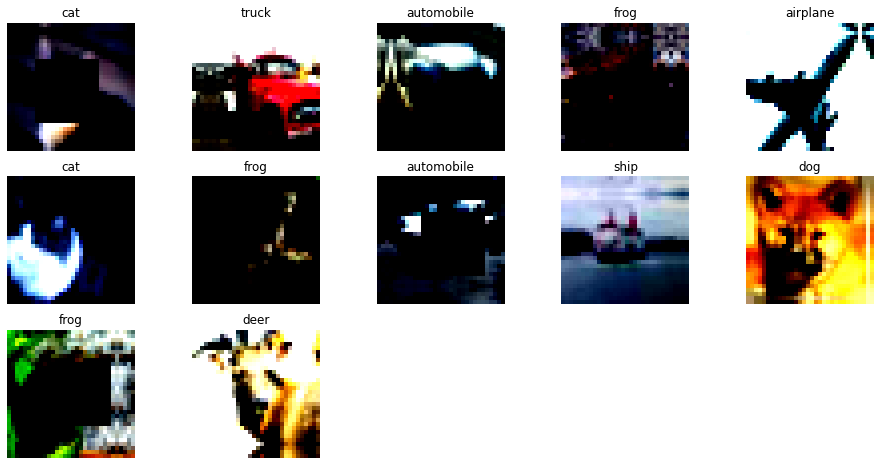

In [9]:
#@title Visualizing Images

from utils.plot_utils import show_batch
show_batch(trainloader,labels,num_images=12) # for visualizing images

In [10]:
#@ Network : Loading Model and understand params, summary
# from models.basic_transformer import BasicTransformer # Model
from models.basic_transformer2 import UltimusModel # Model
from utils.helper import model_summary

model = UltimusModel(device).to(device)

model_summary(model, input_size =(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 48, 32, 32]          13,872
              ReLU-8           [-1, 48, 32, 32]               0
       BatchNorm2d-9           [-1, 48, 32, 32]              96
AdaptiveAvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

In [11]:
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.88E+00


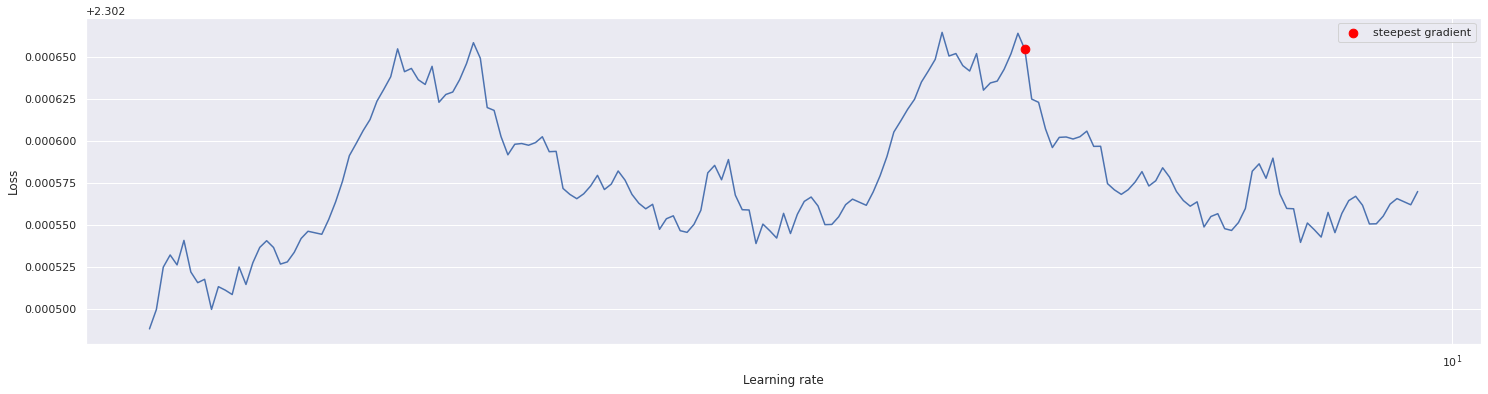

LR at lowest Loss is 1.059560179277616


In [18]:
#@title One Cycle Policy - Finding max and min learning rates
from torch_lr_finder import LRFinder
from utils.lr_utils import find_lr
import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import copy


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1., weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9)

## make a deep copy of the model ..otherwise this would impact original model
model_copy=copy.deepcopy(model)

max_lr = find_lr(model_copy,optimizer,criterion,testloader) # sending test set as it does not have augmentations



In [13]:
#@title Training and Testing loop

import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import torch.nn.functional as F 


criterion = nn.CrossEntropyLoss()

# epochs = 40
epochs = 24
lr = 0.1

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
#                                                  factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,## how much percent of cycle to use for building up, this gives 5
                                                div_factor=10,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation 
                                                final_div_factor=50,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                ) 



In [14]:
from main import trainer, train, test # including wrapper function of train and test
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler)


EPOCH: 1


Loss=2.299006223678589 Batch_id=390 Accuracy=9.84: 100%|██████████| 391/391 [00:23<00:00, 16.60it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=2.305189371109009 Batch_id=390 Accuracy=10.09: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=2.305586338043213 Batch_id=390 Accuracy=9.93: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=2.299985885620117 Batch_id=390 Accuracy=9.77: 100%|██████████| 391/391 [00:20<00:00, 19.27it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=2.305629253387451 Batch_id=390 Accuracy=10.05: 100%|██████████| 391/391 [00:20<00:00, 18.80it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=2.3061912059783936 Batch_id=390 Accuracy=9.67: 100%|██████████| 391/391 [00:19<00:00, 19.65it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=2.2986795902252197 Batch_id=390 Accuracy=10.09: 100%|██████████| 391/391 [00:20<00:00, 18.82it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=2.3084514141082764 Batch_id=390 Accuracy=10.03: 100%|██████████| 391/391 [00:20<00:00, 18.66it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=2.3029298782348633 Batch_id=390 Accuracy=10.02: 100%|██████████| 391/391 [00:20<00:00, 19.36it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=2.303001880645752 Batch_id=390 Accuracy=9.90: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=2.3045361042022705 Batch_id=390 Accuracy=9.85: 100%|██████████| 391/391 [00:21<00:00, 18.51it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=2.3015103340148926 Batch_id=390 Accuracy=9.77: 100%|██████████| 391/391 [00:20<00:00, 19.05it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=2.303438663482666 Batch_id=390 Accuracy=9.90: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=2.307568073272705 Batch_id=390 Accuracy=9.91: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=2.300546407699585 Batch_id=390 Accuracy=9.80: 100%|██████████| 391/391 [00:20<00:00, 19.45it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=2.3055295944213867 Batch_id=390 Accuracy=9.96: 100%|██████████| 391/391 [00:21<00:00, 18.62it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=2.3018293380737305 Batch_id=390 Accuracy=9.94: 100%|██████████| 391/391 [00:20<00:00, 18.99it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=2.306112766265869 Batch_id=390 Accuracy=9.88: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=2.302370548248291 Batch_id=390 Accuracy=9.86: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Loss=2.3033580780029297 Batch_id=390 Accuracy=9.59: 100%|██████████| 391/391 [00:20<00:00, 19.16it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 21


Loss=2.303462028503418 Batch_id=390 Accuracy=9.83: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 22


Loss=2.3037686347961426 Batch_id=390 Accuracy=9.67: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 23


Loss=2.3024277687072754 Batch_id=390 Accuracy=9.67: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 24


Loss=2.302457809448242 Batch_id=390 Accuracy=9.89: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)



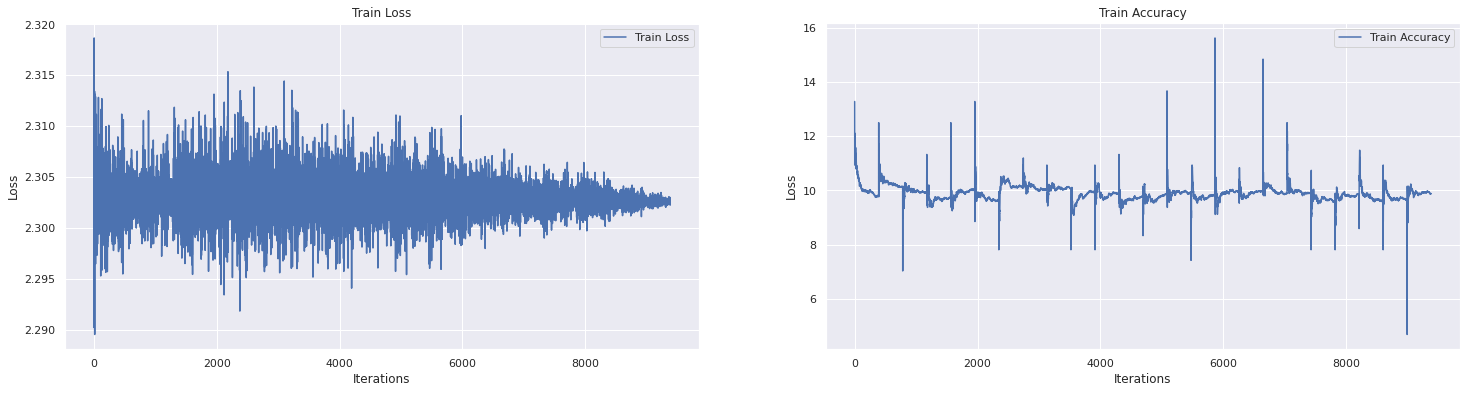

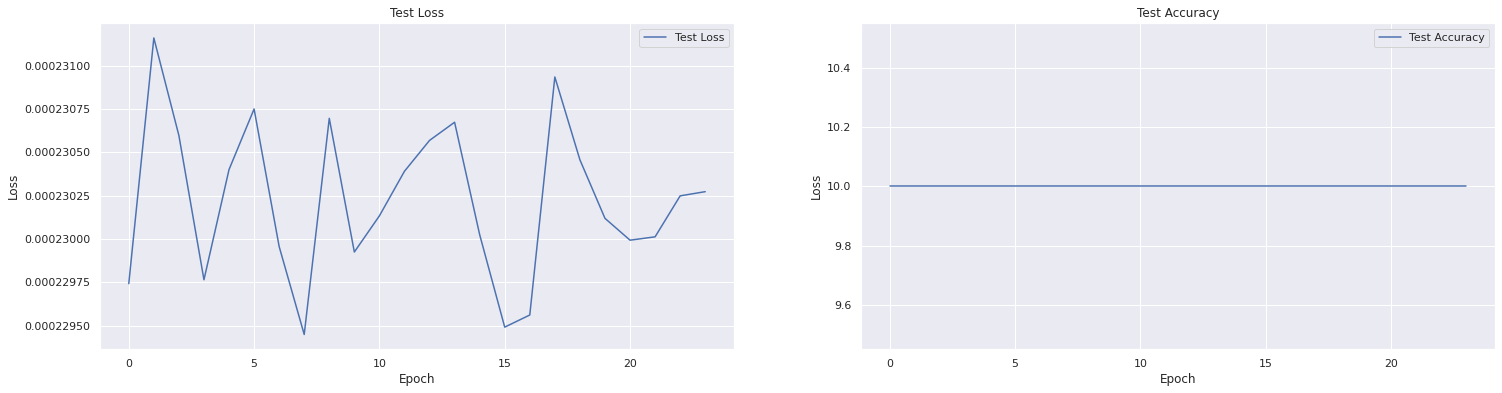

In [15]:
#@title checking results
from utils.plot_utils import plot_metrics

plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)

In [16]:
#@title Checking class level accuracy
from utils.helper import evaluate_classwise_accuracy
evaluate_classwise_accuracy(model, device, labels, testloader)

Accuracy of airplane :  0 %
Accuracy of automobile :  0 %
Accuracy of  bird : 100 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


Total wrong predictions are 9000


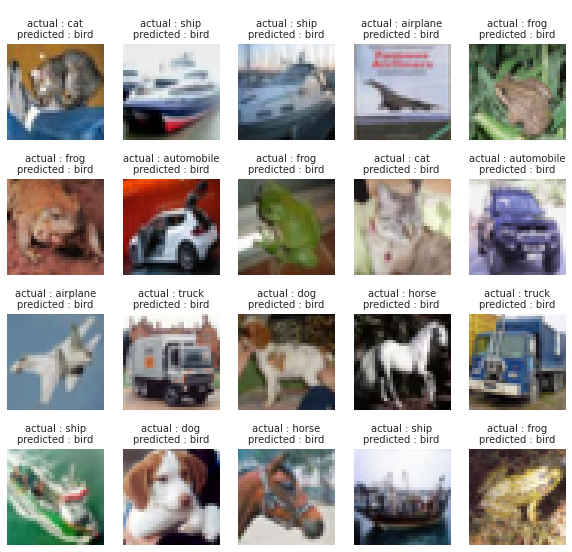

In [17]:
#@title Misclassified Images
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(model, testloader, device, mean, std)